In [1]:
import pandas as pd
import numpy as np
import quest_nullNet as qn
BS_df=pd.DataFrame()
import os
import sys
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
outDir = thisDir + 'output/results/rdmNetwork/'
netRoi=dict([('unassign',14808),('default', 10824),('visual',8736),('fp', 4620),('dan',5264),('van',3151),('salience', 494),('co', 4060),('sm', 2375),('sm-lat', 316),('auditory', 564),('pmn',45),('pon',21)])
for nullNet in netRoi:
    number=netRoi[nullNet]
    for n in range(100):
        #generate a new index
        idx=np.random.randint(55278, size=(number))
        BS=qn.BSmodel(idx)
        BS['feature']=number
        BS['Null_Network']=nullNet
        BS_df=pd.concat([BS_df,BS])
    print('Finished with '+str(nullNet))
BS_df.to_csv(outDir+'BS/nullNet_acc.csv', index=False)

Finished with unassign
Finished with default
Finished with visual
Finished with fp
Finished with dan
Finished with van
Finished with salience
Finished with co
Finished with sm
Finished with sm-lat
Finished with auditory
Finished with pmn
Finished with pon


In [53]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import itertools
from sklearn.preprocessing import StandardScaler #data scaling
from sklearn import decomposition #PCA
#import other python scripts for further anlaysis
import reshape
#import results
import warnings
warnings.filterwarnings("ignore")
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
#outDir = thisDir + 'output/results/'
outDir = thisDir + 'output/results/permutation/'
# Subjects and tasks
taskList=['glass','semantic', 'motor','mem']
#omitting MSC06 for classify All
#subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC07','MSC10']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))

def classifyAll():
    """
    Classifying different subjects along available data rest split into 40 samples to match with task

    Parameters
    -------------

    Returns
    -------------
    df : DataFrame
        Dataframe consisting of average accuracy across all subjects

    """
    final=pd.DataFrame()
    #netRoi=np.logspace(1, 4.2, num=1000,dtype=int)#randomly generate values 10 to 55000
    netRoi=dict([('unassign',14808),('default', 10824),('visual',8736),('fp', 4620),('dan',5264),('van',3151),('salience', 494),('co', 4060),('sm', 2375),('sm-lat', 316),('auditory', 564),('pmn',45),('pon',21)])

    for network in netRoi:
        df=modelAll(network)
        df['network']=network
        df['feature']=netRoi[network]
        final=pd.concat([final,df])
    final.to_csv(outDir+'ALL/shuffle_ROIacc.csv',index=False)
    #final.to_csv(outDir+'ALL/null_ROIacc.csv',index=False)

def modelAll(network):
    """
    Preparing machine learning model with appropriate data

    Parameters
    -------------

    Returns
    -------------
    total_score : float
            Average accuracy of all folds

    """
    clf=RidgeClassifier()
    master_df=pd.DataFrame()
    data=np.array(['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10'],dtype='<U61')
    loo = LeaveOneOut()
    for  test, train in loo.split(data): #train on one sub test on the rest
        tmp=pd.DataFrame()
        train_sub=data[train]
        test_sub=data[test]
    #train sub
        memFC=reshape.permROI(dataDir+'mem/'+train_sub[0]+'_parcel_corrmat.mat')
        semFC=reshape.permROI(dataDir+'semantic/'+train_sub[0]+'_parcel_corrmat.mat')
        glassFC=reshape.permROI(dataDir+'glass/'+train_sub[0]+'_parcel_corrmat.mat')
        motFC=reshape.permROI(dataDir+'motor/'+train_sub[0]+'_parcel_corrmat.mat')
        restFC=reshape.permROI(dataDir+'rest/corrmats_timesplit/fourths/'+train_sub[0]+'_parcel_corrmat.mat') #keep tasks seperated in order to collect the right amount of days
        restFC=np.reshape(restFC,(10,4,55278)) #reshape to gather correct days
        #return taskFC,restFC, test_taskFC,test_restFC
        diff=K_folds(network,train_sub[0], clf, memFC,semFC,glassFC,motFC, restFC)
        tmp['train']=train_sub
        tmp['acc']=diff
        master_df=pd.concat([master_df,tmp])
    return master_df

def K_folds(network, train_sub, clf, memFC,semFC,glassFC,motFC,restFC):
    """
    Cross validation to train and test using nested loops

    Parameters
    -----------
    clf : obj
        Machine learning algorithm
    taskFC, restFC, test_taskFC, test_restFC : array_like
        Input arrays, training and testing set of task and rest FC
    Returns
    -----------
    total_score : float
        Average accuracy across folds
    acc_score : list
        List of accuracy for each outer fold
    """
    refROI=pd.read_csv(thisDir+'output/results/permutation/ALL/ref_acc.csv') #for taking differece
    refROI.drop(columns=['diff_sub'],inplace=True)
    ref=refROI[refROI['train']==train_sub].same_sub.values
    ref_sub=ref[0]
    ref_sub=round(ref_sub,2)
    kf = KFold(n_splits=5)

    CVacc=[]
    df=pd.DataFrame()

    #fold each training set
    if train_sub=='MSC03':
        split=np.empty((8,55278))
        #xtrainSize=24
        #xtestSize=4
    elif train_sub=='MSC06' or train_sub=='MSC07':
        split=np.empty((9,55278))
    else:
        split=np.empty((10,55278))
    for train_index, test_index in kf.split(split):
        memtrain, memval=memFC[train_index], memFC[test_index]
        semtrain, semval=semFC[train_index], semFC[test_index]
        mottrain, motval=motFC[train_index], motFC[test_index]
        glatrain, glaval=glassFC[train_index], glassFC[test_index]
        Xtrain_task=np.concatenate((memtrain,semtrain,mottrain,glatrain))
        Xtrain_rest, Xval_rest=restFC[train_index,:,:], restFC[test_index,:,:]
        Xval_task=np.concatenate((memval,semval,motval,glaval))
        Xtrain_rest=np.reshape(Xtrain_rest,(-1,55278))
        Xval_rest=np.reshape(Xval_rest,(-1,55278))
        ytrain_task = np.ones(Xtrain_task.shape[0], dtype = int)
        ytrain_rest=np.zeros(Xtrain_rest.shape[0], dtype=int)
        yval_task = np.ones(Xval_task.shape[0], dtype = int)
        yval_rest=np.zeros(Xval_rest.shape[0], dtype=int)

        XtrainNew_task, XtrainNew_rest=reshape.permuteIndices(Xtrain_task,Xtrain_rest,network)
        X_tr=np.concatenate((XtrainNew_task, XtrainNew_rest))
        X_val=np.concatenate((Xval_task, Xval_rest))
        y_tr = np.concatenate((ytrain_task,ytrain_rest))
        y_val=np.concatenate((yval_task, yval_rest))
        clf.fit(X_tr,y_tr)
        #cross validation
        CV_score=clf.score(X_val, y_val)
        CVacc.append(CV_score)
    df['cv']=CVacc
    #Different sub outer acc
    same_sub_score=df['cv'].mean()
    same=round(same_sub_score,2)
    diff=same - ref_sub 
    d=round(diff,2)
    return d

In [54]:
df=modelAll('unassign')

In [52]:
df

,train,acc
0,MSC01,-0.04
0,MSC02,-0.05
0,MSC03,-0.08
0,MSC04,-0.04
0,MSC05,0.01
0,MSC06,0.01
0,MSC07,0.01
0,MSC10,-0.08


In [55]:
df

,train,acc
0,MSC01,-0.03
0,MSC02,-0.05
0,MSC03,-0.02
0,MSC04,-0.04
0,MSC05,0.01
0,MSC06,0.01
0,MSC07,0.00
0,MSC10,-0.05


In [2]:
import matlab.engine
import scipy.io
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
df=thisDir+'data/mvpa_data/mem/MSC01_parcel_corrmat.mat' #use as temp for knowing size
fileFC=scipy.io.loadmat(df)
Parcel_params = reshape.loadParcelParams('Gordon333','/Users/Alexis/Desktop/MSC_Alexis/analysis/data/Parcel_info/')
roi_sort = np.squeeze(Parcel_params['roi_sort'])

In [3]:
roi_sort

array([ 10,  17,  18,  72, 114, 117, 118, 119, 120, 121, 122, 123, 124,
       127, 128, 132, 133, 134, 141, 143, 158, 171, 177, 178, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 295, 296, 299,
       300, 301, 302, 303, 304, 305, 311, 313,   0,   3,   5,  24,  25,
        43,  93, 113, 115, 116, 125, 126, 144, 145, 149, 150, 151, 153,
       155, 156, 161, 164, 183, 185, 199, 219, 224, 256, 258, 277, 278,
       289, 314, 315, 320, 321, 322, 323, 324, 325, 330,   4,   7,  14,
        15,  16,  19,  89,  96,  97,  98, 130, 131, 135, 136, 137, 138,
       139, 140, 165, 168, 174, 175, 176, 250, 254, 255, 257, 262, 263,
       264, 266, 292, 297, 298, 306, 307, 308, 309, 310,   6,   8,  23,
        77,  95, 107, 108, 147, 148, 166, 167, 169, 181, 239, 259, 260,
       271, 272, 275, 276, 318, 319, 326, 327,  40,  41,  42,  48,  50,
        51,  54,  73,  86,  87,  90,  91,  94,  99, 105, 106, 109, 112,
       154, 188, 198, 202, 207, 210, 235, 249, 251, 252, 261, 26

In [6]:
MSC01=np.genfromtxt('/Users/Alexis/Desktop/MSC_Alexis/analysis/output/results/permutation/ALL/subs/MSC01_Row.csv',delimiter=',')

In [14]:
data={'names':MSC01,'roi':roi_sort}
df=pd.DataFrame(data)

In [17]:
df.sort_values(by='roi',inplace=True)

In [18]:
array=df['names'].to_numpy()

In [24]:
array[2]

-0.03749999999999998

In [22]:
df

,names,roi
47,0.0000,0
250,-0.0125,1
288,-0.0375,2
48,-0.0125,3
88,0.0000,4
...,...,...
318,0.0000,328
319,-0.0125,329
87,-0.0125,330
204,-0.0125,331


In [26]:
import reshape
indices=reshape.getIndices()
memFC=reshape.permROI(dataDir+'mem/MSC01_parcel_corrmat.mat')

In [27]:
indices

,level_0,level_1,variable_0,variable_1,value
0,unassign,0,unassign,1,0.022631
1,unassign,0,unassign,2,0.117758
2,unassign,1,unassign,2,0.298062
3,unassign,0,unassign,3,0.442273
4,unassign,1,unassign,3,0.118008
...,...,...,...,...,...
55273,pon,327,pon,332,0.524179
55274,pon,328,pon,332,0.443304
55275,pon,329,pon,332,0.119601
55276,pon,330,pon,332,0.574670


In [31]:
refROI=pd.read_csv(thisDir+'output/results/permutation/ALL/ref_acc.csv') #for taking differece


In [32]:
refROI

,train,same_sub,diff_sub
0,MSC01,1.0000,0.579820
1,MSC02,0.9875,0.840360
2,MSC03,0.9750,0.798564
3,MSC04,0.9750,0.637838
4,MSC05,0.9875,0.717477
5,MSC06,0.9750,0.799641
6,MSC07,0.9875,0.818705
7,MSC10,0.9750,0.603243


In [33]:
refROI.drop(columns=['diff_sub'],inplace=True)
ref=refROI[refROI['train']=='MSC01'].same_sub.values

In [35]:
ref[0]

1.0

In [1]:
import masterClass as c
c.classifySS()

In [3]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import itertools
import scipy.io
import random
from sklearn.model_selection import KFold
import os
import sys
import reshape
from statistics import mean
import seperate_task as s
#import other python scripts for further anlaysis
# Initialization of directory information:
#thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/results/acc/'
# Subjects and tasks
taskList=['semantic','glass', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
clf=RidgeClassifier()

#train sub
master_df=pd.DataFrame()
data=np.array(['MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10'],dtype='<U61')
loo = LeaveOneOut()
#for  test, train in loo.split(data): #train on one sub test on the rest
tmp=pd.DataFrame()

#train sub
memFC=reshape.matFiles(dataDir+'mem/MSC01_parcel_corrmat.mat')
semFC=reshape.matFiles(dataDir+'semantic/MSC01_parcel_corrmat.mat')
glassFC=reshape.matFiles(dataDir+'glass/MSC01_parcel_corrmat.mat')
motFC=reshape.matFiles(dataDir+'motor/MSC01_parcel_corrmat.mat')
restFC=reshape.matFiles(dataDir+'rest/corrmats_timesplit/fourths/MSC01_parcel_corrmat.mat') #keep tasks seperated in order to collect the right amount of days
nsize=restFC.shape[1]
restFC=np.reshape(restFC,(10,4,nsize)) #reshape to gather correct days
#test sub
test_taskFC,test_restFC=s.AllSubFiles(data)
DSRacc=s.K_folds('MSC01', clf, memFC,semFC,glassFC,motFC, restFC, test_taskFC,test_restFC)


In [4]:
test_restFC.shape

(70, 55278)

In [6]:
mean(DSRacc)

0.12571428571428572

In [ ]:
import pandas as pd
import numpy as np
import featSelect_speed as fs
import os
import sys
import reshape
from statistics import mean
#import other python scripts for further anlaysis
# Initialization of directory information:
#thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/results/rdmNetwork/'
ALL_df=pd.DataFrame()
#generate log sample
#1000 points for log selection
#loop through 125 times to generate 8*125=1000 samples per log point
featureSize=np.logspace(1, 4.7, num=39,dtype=int)
for i in range(100):
    for number in featureSize:
        #generate a new index
        idx=np.random.randint(55278, size=(number))
        ALL=fs.modelAll(idx)
        ALL['feature']=number
        ALL_df=pd.concat([ALL_df,ALL])
    print('Finished with '+str(i)+' in iteration 100')
ALL_df.to_csv(outDir+'ALL/acc.csv', index=False)

Finished with 0 in iteration 100
Finished with 1 in iteration 100
Finished with 2 in iteration 100
Finished with 3 in iteration 100
Finished with 4 in iteration 100
Finished with 5 in iteration 100
Finished with 6 in iteration 100
Finished with 7 in iteration 100
Finished with 8 in iteration 100
Finished with 9 in iteration 100
Finished with 10 in iteration 100
Finished with 11 in iteration 100
Finished with 12 in iteration 100
Finished with 13 in iteration 100
Finished with 14 in iteration 100
Finished with 15 in iteration 100
Finished with 16 in iteration 100
Finished with 17 in iteration 100
Finished with 18 in iteration 100
Finished with 19 in iteration 100
Finished with 20 in iteration 100
Finished with 21 in iteration 100
Finished with 22 in iteration 100
Finished with 23 in iteration 100
Finished with 24 in iteration 100
Finished with 25 in iteration 100
Finished with 26 in iteration 100
Finished with 27 in iteration 100
Finished with 28 in iteration 100
Finished with 29 in iter

In [3]:
import numpy as np

foo=np.full(10,2)

In [4]:
foo

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/Predictions/seperate_task.py:561: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/Users/Alexis/Desktop/MSC_Alexis/analysis/code/mL_rsfMRI/Predictions/seperate_task.py:564: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until 

<Figure size 432x288 with 0 Axes>

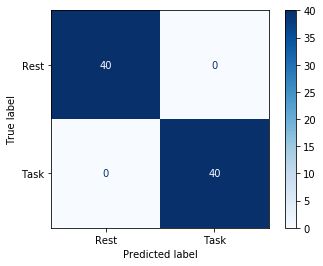

<Figure size 432x288 with 0 Axes>

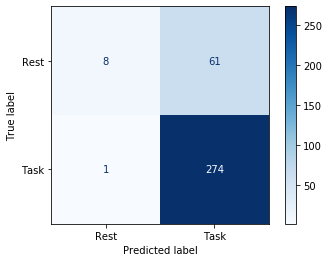

<Figure size 432x288 with 0 Axes>

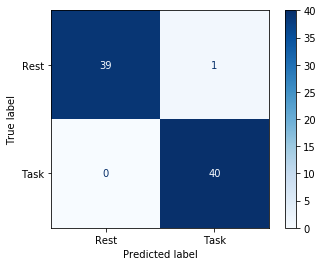

<Figure size 432x288 with 0 Axes>

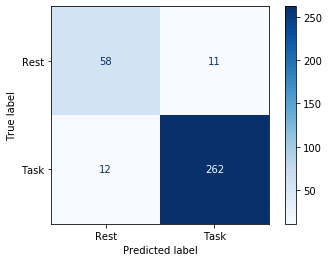

<Figure size 432x288 with 0 Axes>

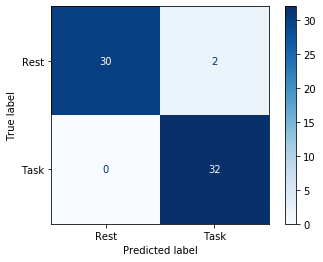

<Figure size 432x288 with 0 Axes>

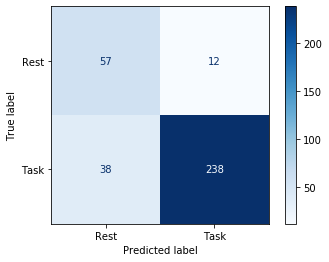

<Figure size 432x288 with 0 Axes>

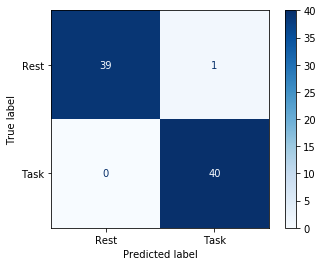

<Figure size 432x288 with 0 Axes>

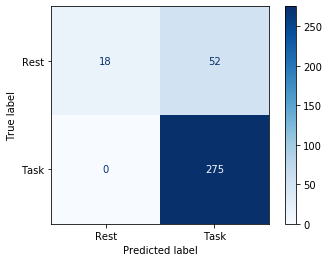

<Figure size 432x288 with 0 Axes>

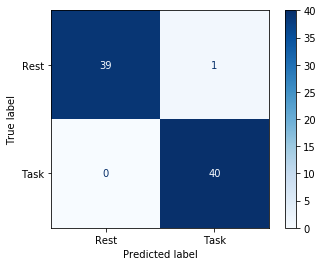

<Figure size 432x288 with 0 Axes>

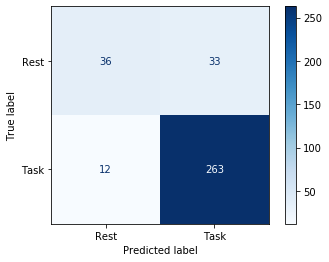

<Figure size 432x288 with 0 Axes>

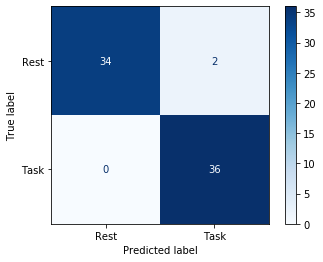

<Figure size 432x288 with 0 Axes>

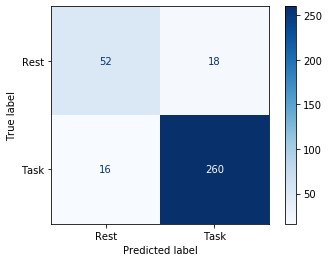

<Figure size 432x288 with 0 Axes>

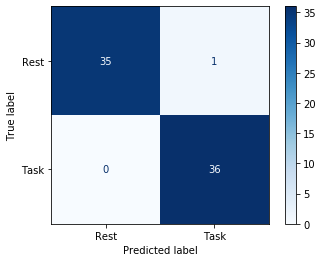

<Figure size 432x288 with 0 Axes>

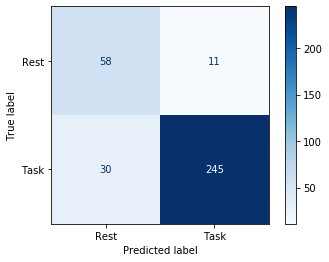

<Figure size 432x288 with 0 Axes>

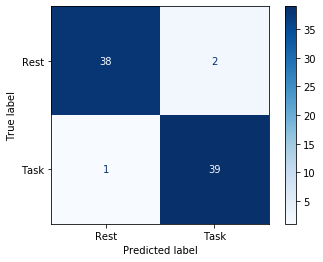

<Figure size 432x288 with 0 Axes>

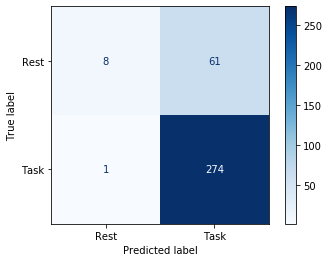

In [1]:
import seperate_task as st
import pandas as pd
st.modelAll()

In [13]:
import numpy as np
foo=np.array([[0,0],[0,0]])
for i in range(5):
    foo=foo+CV_cm
#CV_cm+DS_cm

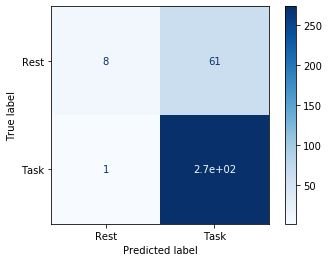

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plt.figure()
cm=DS_cm[0]
ax =ConfusionMatrixDisplay(cm,display_labels=['Rest','Task']).plot(cmap=plt.cm.Blues)
plt.savefig(outDir+'ALL/same/'+train_sub+'.png', bbox_inches='tight')

array([[  8.,  61.],
       [  1., 274.]])

In [17]:
import numpy as np
t=np.empty((2,2,2))
DS_tmp=np.array([[20, 50],[5,271]])


In [18]:
t.shape

(2, 2, 2)

In [19]:
t[0]=DS_cm
t[1]=DS_tmp


In [21]:
t.mean(axis=0)

array([[ 15. ,  55. ],
       [  3. , 272.5]])

In [22]:
DS_tmp

array([[ 20,  50],
       [  5, 271]])

In [1]:
import seperate_task as st
st.SSmodel()

In [4]:
diff

array([[65,  4,  0,  0,  0],
       [ 9, 57,  0,  0,  0],
       [26, 19, 16,  0,  7],
       [33, 21,  2,  2,  9],
       [12, 10,  0,  0, 45]])

In [1]:
import DTmST
DTmST.CVmSS()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27